In [2]:

import helper_bert as hb
import helper_nlp as hnlp

import numpy as np
import pandas as pd
import shap
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from helper_bert import integrated_gradients_positive, plot_ig
from helper_nlp import nlp_classifier_prob, preprocess_text_str

/home/mkas/Free_text_analysis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("free_text_data.csv")
df_tmp = df.dropna().groupby("chiffre")[["aboutme", "scam_flag"]].last().sample(n=1000)
X = df_tmp.aboutme
y = df_tmp.scam_flag

In [4]:
# --- Assumptions ---
# - You already have:
#     checkpts: str  (path to a fine-tuned HF checkpoint dir, e.g. "./results/checkpoint-1200" or "./best_model")
#     X: pd.Series or list[str]  (raw texts)
#     y: pd.Series or np.array   (0/1 labels)
# - You have the improved helper modules available:
#     from helper_bert import integrated_gradients_positive
#     from helper_nlp import nlp_classifier_prob, preprocess_text_str
#
# - You have SHAP installed:
#     pip install shap
#
# This script:
# 1) loads your trained BERT checkpoint
# 2) trains a BoW+RF model
# 3) computes SHAP values for a few samples
# 4) computes BERT IG for the same samples
# 5) compares them (overlap + correlation on shared unigrams)



# -------------------------
# Utilities: IG token cleanup (WordPiece -> words)
# -------------------------

def merge_wordpieces(tokens, scores):
    """
    Merge BERT WordPieces:
      ["un", "##believ", "##able"] -> ["unbelievable"]
    score aggregation: sum (you could also use mean; sum is fine for "contribution").
    Removes [CLS]/[SEP]/[PAD].
    """
    merged_tokens = []
    merged_scores = []

    buff_tok = ""
    buff_score = 0.0

    def flush():
        nonlocal buff_tok, buff_score
        if buff_tok:
            merged_tokens.append(buff_tok)
            merged_scores.append(buff_score)
        buff_tok = ""
        buff_score = 0.0

    for tok, sc in zip(tokens, scores):
        if tok in ("[CLS]", "[SEP]", "[PAD]"):
            continue

        if tok.startswith("##"):
            # continuation
            buff_tok += tok[2:]
            buff_score += sc
        else:
            # new token
            flush()
            buff_tok = tok
            buff_score = sc

    flush()
    return merged_tokens, merged_scores


def ig_top_unigrams(text, bert_model, bert_tokenizer, steps=64, baseline="pad", top_k=20):
    """
    Returns a DataFrame of top-k tokens by |IG| (merged WordPieces).
    """
    res = integrated_gradients_positive(
        bert_model, bert_tokenizer, text=text, steps=steps, baseline=baseline
    )
    toks, scs = merge_wordpieces(res["tokens"], res["attributions_norm"])
    df = pd.DataFrame({"token": toks, "ig_norm": scs})
    df["abs_ig"] = df["ig_norm"].abs()
    df = df.sort_values("abs_ig", ascending=False).head(top_k).reset_index(drop=True)
    df["p_pos_bert"] = res["p_pos"]
    return df


# -------------------------
# Utilities: SHAP for BoW RF
# -------------------------

def shap_values_positive(tree_explainer, X_vec, rf_model):
    """
    Robust extraction of SHAP values for the positive class.

    SHAP output varies by version:
    - list of arrays (one per class) -> pick class index for label 1
    - array of shape (n, features, classes) -> slice [:, :, class_idx]
    - array of shape (n, features) for binary (sometimes already positive)
    """
    sv = tree_explainer.shap_values(X_vec)

    # Determine which class index corresponds to label 1 in sklearn RF
    # (rf_model.classes_ could be [0,1] or [1,0] in weird cases)
    class_idx = int(np.where(rf_model.classes_ == 1)[0][0])

    if isinstance(sv, list):
        # sv[class] shape: (n, features)
        return sv[class_idx]
    sv = np.asarray(sv)
    if sv.ndim == 3:
        # (n, features, classes)
        return sv[:, :, class_idx]
    if sv.ndim == 2:
        # (n, features)
        return sv
    raise ValueError(f"Unexpected SHAP values shape: {sv.shape}")


def bow_shap_for_text(
    text,
    rf_model,
    vectorizer,
    lang="en",
    top_k=20,
    shap_background_vec=None,
):
    proc = preprocess_text_str(text, lang=lang)

    # Vectorize and FORCE dense float32
    X_vec = vectorizer.transform([proc])
    X_dense = X_vec.toarray().astype(np.float32)

    # Background: optional, but if given FORCE dense float32
    if shap_background_vec is not None:
        bg = shap_background_vec
        if hasattr(bg, "toarray"):
            bg = bg.toarray()
        bg = np.asarray(bg, dtype=np.float32)
        explainer = shap.TreeExplainer(rf_model, data=bg)
    else:
        explainer = shap.TreeExplainer(rf_model)

    # Use the "new" API if available, else fall back
    try:
        exp = explainer(X_dense)
        values = exp.values
        base_values = exp.base_values
    except Exception:
        values = explainer.shap_values(X_dense)
        base_values = explainer.expected_value

    # Select positive class robustly
    class_idx = int(np.where(rf_model.classes_ == 1)[0][0])

    if isinstance(values, list):          # old API, list per class
        sv_pos = values[class_idx][0]
    else:
        values = np.asarray(values)
        if values.ndim == 3:             # (n, features, classes)
            sv_pos = values[0, :, class_idx]
        else:                             # (n, features)
            sv_pos = values[0]

    feature_names = np.array(vectorizer.get_feature_names_out())
    df = pd.DataFrame({"feature": feature_names, "shap": sv_pos})
    df["abs_shap"] = df["shap"].abs()
    df = df.sort_values("abs_shap", ascending=False).head(top_k).reset_index(drop=True)

    # BoW predicted proba
    proba_pos = float(rf_model.predict_proba(X_dense)[0, class_idx])
    df["p_pos_bow"] = proba_pos

    return df



# -------------------------
# Comparison: overlap + correlation on shared unigrams
# -------------------------

def compare_ig_shap(
    text,
    bert_model,
    bert_tokenizer,
    rf_model,
    vectorizer,
    lang="en",
    steps=64,
    baseline="pad",
    top_k=20,
    shap_background_vec=None,
):
    ig_df = ig_top_unigrams(
        text, bert_model, bert_tokenizer, steps=steps, baseline=baseline, top_k=top_k
    )
    shap_df = bow_shap_for_text(
        text, rf_model, vectorizer, lang=lang, shap_background_vec=shap_background_vec, top_k=top_k
    )

    # Normalize tokens/features to a comparable space:
    # - IG token is already lower-ish; strip punctuation-ish
    # - SHAP features are already unigrams if you trained with ngram_range=(1,1)
    ig_df["token_norm"] = ig_df["token"].str.lower()
    shap_df["feature_norm"] = shap_df["feature"].str.lower()

    # Overlap of top-k
    ig_top = set(ig_df["token_norm"])
    shap_top = set(shap_df["feature_norm"])
    overlap = sorted(list(ig_top.intersection(shap_top)))

    # Correlation on shared tokens (signed)
    merged = pd.merge(
        ig_df[["token_norm", "ig_norm"]],
        shap_df[["feature_norm", "shap"]],
        left_on="token_norm",
        right_on="feature_norm",
        how="inner",
    )
    if len(merged) >= 3:
        corr = merged["ig_norm"].corr(merged["shap"])
    else:
        corr = np.nan

    summary = {
        "text": text,
        "bert_p_pos": float(ig_df["p_pos_bert"].iloc[0]) if len(ig_df) else np.nan,
        "bow_p_pos": float(shap_df["p_pos_bow"].iloc[0]) if len(shap_df) else np.nan,
        "topk_overlap": overlap,
        "corr_signed_on_overlap": corr,
        "n_overlap": len(merged),
    }

    return summary, ig_df, shap_df, merged

In [5]:
# =========================
# Train BoW + RF using helper_nlp
#    IMPORTANT: set ngram_range=(1,1) to make SHAP features comparable to IG tokens
# =========================

df = pd.DataFrame({"text": pd.Series(X).astype(str), "label": pd.Series(y).astype(int)})

rf_result = nlp_classifier_prob(
    df=df,
    col_name="text",
    target_col="label",
    lang="en",                 # switch if needed
    max_features=2000,
    rf_params={"n_estimators": 300, "max_depth": None, "n_jobs": -1},
    ngram_range=(1, 1),        # <-- key for a clean comparison
    bow=True,
    test_size=0.2,
    seed=42,
)

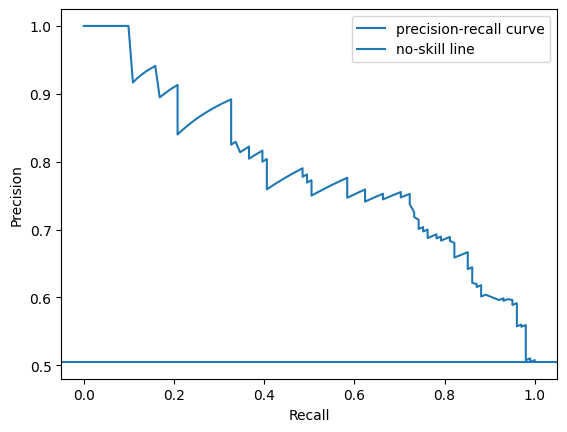

In [6]:
from helpers import plot_pr_curve

plot_pr_curve(rf_result.y_test, rf_result.test_pred_proba)

In [8]:
# =========================
# 1) Load trained BERT checkpoint (no retraining)
# =========================

from helper_bert import get_predictions

checkpts = "./results/checkpoint-112/"
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(checkpts)
model.eval()

pred = get_predictions(
    model=model,
    tokenizer=tokenizer,
    texts=X,
)

print(pred["proba_pos"][:5])


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


[0.99477345 0.99485296 0.9879654  0.98322105 0.98635244]


In [10]:
pred.keys()

dict_keys(['logits', 'proba_pos', 'pred_labels'])

In [13]:

# Optional: background for SHAP (small sample of training vectors)
# This can help some SHAP modes; safe to keep small.
# Here we just build it from a random slice of the *whole* dataset for simplicity.
bg_texts = df["text"].sample(min(200, len(df)), random_state=42).tolist()
bg_proc = [preprocess_text_str(t, lang="en") for t in bg_texts]
shap_background_vec = vectorizer.transform(bg_proc).toarray().astype(np.float32)

# pick examples with y==1 if you want to explain positives
pos_texts = df.loc[df["label"] == 1, "text"].sample(min(5, (df["label"] == 1).sum()), random_state=1).tolist()


# Compare SHAP vs IG per sample

for i, text in enumerate(pos_texts, 1):
    summary, ig_df, shap_df, merged = compare_ig_shap(
        text=text,
        bert_model=bert_model,
        bert_tokenizer=bert_tokenizer,
        rf_model=rf_model,
        vectorizer=vectorizer,
        lang="en",
        steps=64,
        baseline="pad",
        top_k=20,
        shap_background_vec=shap_background_vec,
    )

    print(f"\n--- Sample {i} ---")
    print("BERT P(y=1):", round(summary["bert_p_pos"], 4), "| BoW RF P(y=1):", round(summary["bow_p_pos"], 4))
    print("Top-k overlap:", summary["topk_overlap"])
    print("Signed corr on overlap:", summary["corr_signed_on_overlap"], " (n_overlap =", summary["n_overlap"], ")")

    print("\nTop IG tokens:")
    print(ig_df[["token", "ig_norm", "abs_ig"]].head(10).to_string(index=False))

    print("\nTop SHAP features:")
    print(shap_df[["feature", "shap", "abs_shap"]].head(10).to_string(index=False))

    if len(merged):
        print("\nOverlap (token -> IG vs SHAP):")
        print(merged[["token_norm", "ig_norm", "shap"]].sort_values("token_norm").to_string(index=False))



--- Sample 1 ---
BERT P(y=1): 0.9889 | BoW RF P(y=1): 0.8624
Top-k overlap: ['create', 'face', 'home', 'hope', 'meet', 'willing']
Signed corr on overlap: -0.48902263020333264  (n_overlap = 6 )

Top IG tokens:
   token  ig_norm   abs_ig
     and 1.000000 1.000000
    home 0.770194 0.770194
       ' 0.679654 0.679654
       s 0.602593 0.602593
together 0.572734 0.572734
  create 0.453153 0.453153
       i 0.346098 0.346098
      to 0.338219 0.338219
    hope 0.319677 0.319677
      to 0.315898 0.315898

Top SHAP features:
     feature      shap  abs_shap
        meet  0.170278  0.170278
     willing  0.044092  0.044092
        hope  0.038776  0.038776
        face  0.017556  0.017556
        home -0.016027  0.016027
         man -0.011195  0.011195
        work  0.010170  0.010170
      friend  0.009883  0.009883
       thing  0.009545  0.009545
relationship -0.009444  0.009444

Overlap (token -> IG vs SHAP):
token_norm  ig_norm      shap
    create 0.453153  0.007094
      face 0.24551

In [ ]:
def plot_ig(
    trained: BertTrained,
    tokenizer,
    text: str,
    steps: int = 64,
    baseline: str = "pad",
    thresh: float = 0.1,
    max_length: Optional[int] = None,
):